In [2]:
import os


from fastai.vision.all import *

import warnings
warnings.filterwarnings('ignore')


#### CONFIGURATION

In [3]:
PATH_IMG = 'data/input/'
MODEL_PATH = 'models/'
PATH_IMG_TRAIN = os.path.join(PATH_IMG, 'train/')

DEFAULT_FIGSIZE = (7,6)

#### FUNCTIONS DEFINITION

In [4]:
# Plot training metrics function
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
def GetLabel(fileName):
    return fileName.split('-')[0]

## MODEL TRAINING

In [5]:
image_categories = os.listdir(PATH_IMG_TRAIN)
print(f"Categories found: {image_categories}")

Categories found: ['baseball', 'cricket', 'football']


<AxesSubplot:>

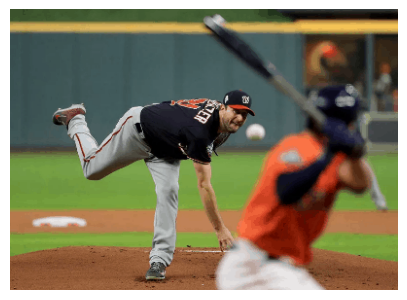

In [6]:
# Sample image printing
category_path = os.path.join(PATH_IMG_TRAIN, image_categories[0])
img_path = os.path.join(category_path, os.listdir(category_path)[0])
img = PILImage.create(img_path)
img.show()

#### Files images labeling

In [7]:
labelA = image_categories[0]
labelB = image_categories[1]
labelC = image_categories[2]

for img in get_image_files(PATH_IMG_TRAIN): 
  if (labelA in str(img)) & (labelA not in (str(img).split('\\')[-1])):
    img.rename(f"{img.parent}/{labelA}-{img.name}")
  elif (labelB in str(img)) & (labelB not in (str(img).split('\\')[-1])):
    img.rename(f"{img.parent}/{labelB}-{img.name}")
  elif (labelC in str(img)) & (labelC not in (str(img).split('\\')[-1])):
    img.rename(f"{img.parent}/{labelC}-{img.name}")
  else:
    pass

In [8]:
number_images = len(get_image_files(PATH_IMG_TRAIN))
print(f'{number_images} images in train set')

210 images in train set


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


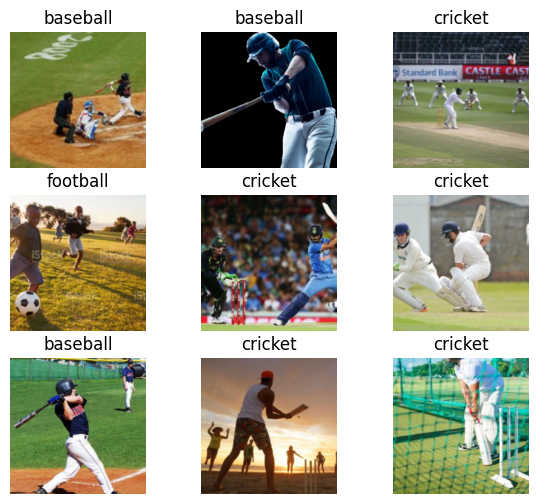

In [9]:
# Defining data loader
dls = ImageDataLoaders.from_name_func(
    PATH_IMG_TRAIN,
    get_image_files(PATH_IMG_TRAIN),
    valid_pct=0.2,
    seed=42,
    label_func=GetLabel,
    item_tfms=Resize(224),
    device=torch.device('cpu'),
    shuffle_train=True
    )

dls.train.show_batch(figsize=DEFAULT_FIGSIZE)

In [10]:
# Train model for 10 epochs
learn = vision_learner(
    dls,
    resnet34,
    metrics=accuracy,
    pretrained=True
    )
learn.dls.cpu()
learn.fine_tune(epochs=10)

epoch,train_loss,valid_loss,accuracy,time
0,2.027840,2.802790,0.261905,00:38


epoch,train_loss,valid_loss,accuracy,time
0,1.654265,1.608447,0.357143,00:49
1,1.418365,0.846910,0.666667,00:44
2,1.204023,0.389685,0.833333,00:38
3,0.974954,0.250452,0.928571,00:44
4,0.808768,0.217531,0.904762,00:44
5,0.681939,0.214638,0.904762,00:40
6,0.585815,0.217822,0.928571,00:38
7,0.505282,0.231293,0.904762,00:38
8,0.443663,0.238277,0.928571,00:37
9,0.394680,0.253420,0.928571,00:34


#### MODEL RESULTS AND METRICS

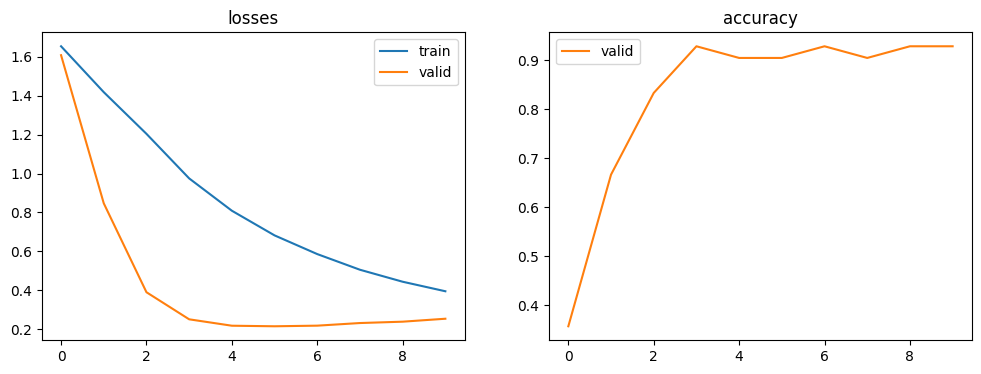

In [11]:
learn.recorder.plot_metrics()

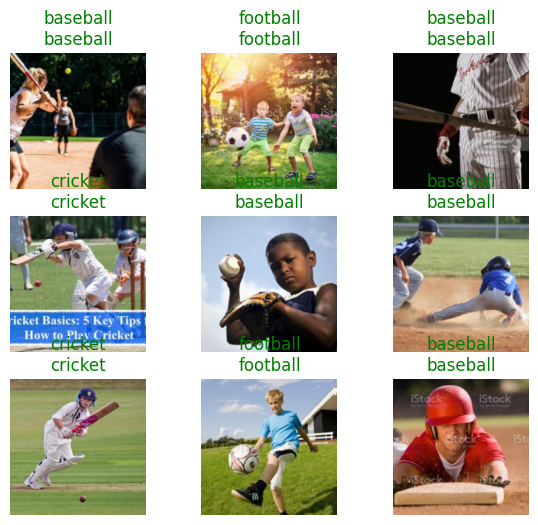

In [12]:
learn.show_results(figsize=DEFAULT_FIGSIZE)

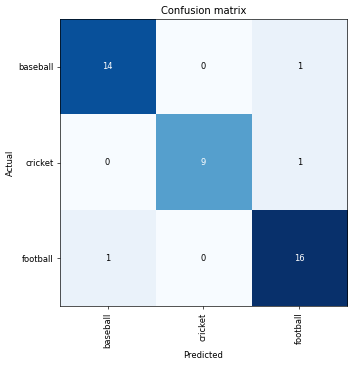

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=DEFAULT_FIGSIZE, dpi=60)

In [14]:
interp.print_classification_report()

              precision    recall  f1-score   support

    baseball       0.93      0.93      0.93        15
     cricket       1.00      0.90      0.95        10
    football       0.89      0.94      0.91        17

    accuracy                           0.93        42
   macro avg       0.94      0.92      0.93        42
weighted avg       0.93      0.93      0.93        42



# Save model

In [15]:
learn.path = Path(MODEL_PATH)
learn.export('model.pkl') 